In [5]:
%load_ext autoreload
%autoreload 2
from src.models.representation.vae import *
from src.models.representation.vae.vae import RecurrentVaeWithTeacherForcing
from src.models.representation.vae.decoder.recurrent_decoder import LSTMVaeDecoderWithTeacherForcing
from src.dataloader.dataset import *

import pickle

import torch

dataset = pickle.load(open("data/preprocessed_note_events.pkl", "rb"))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(160000, 4)


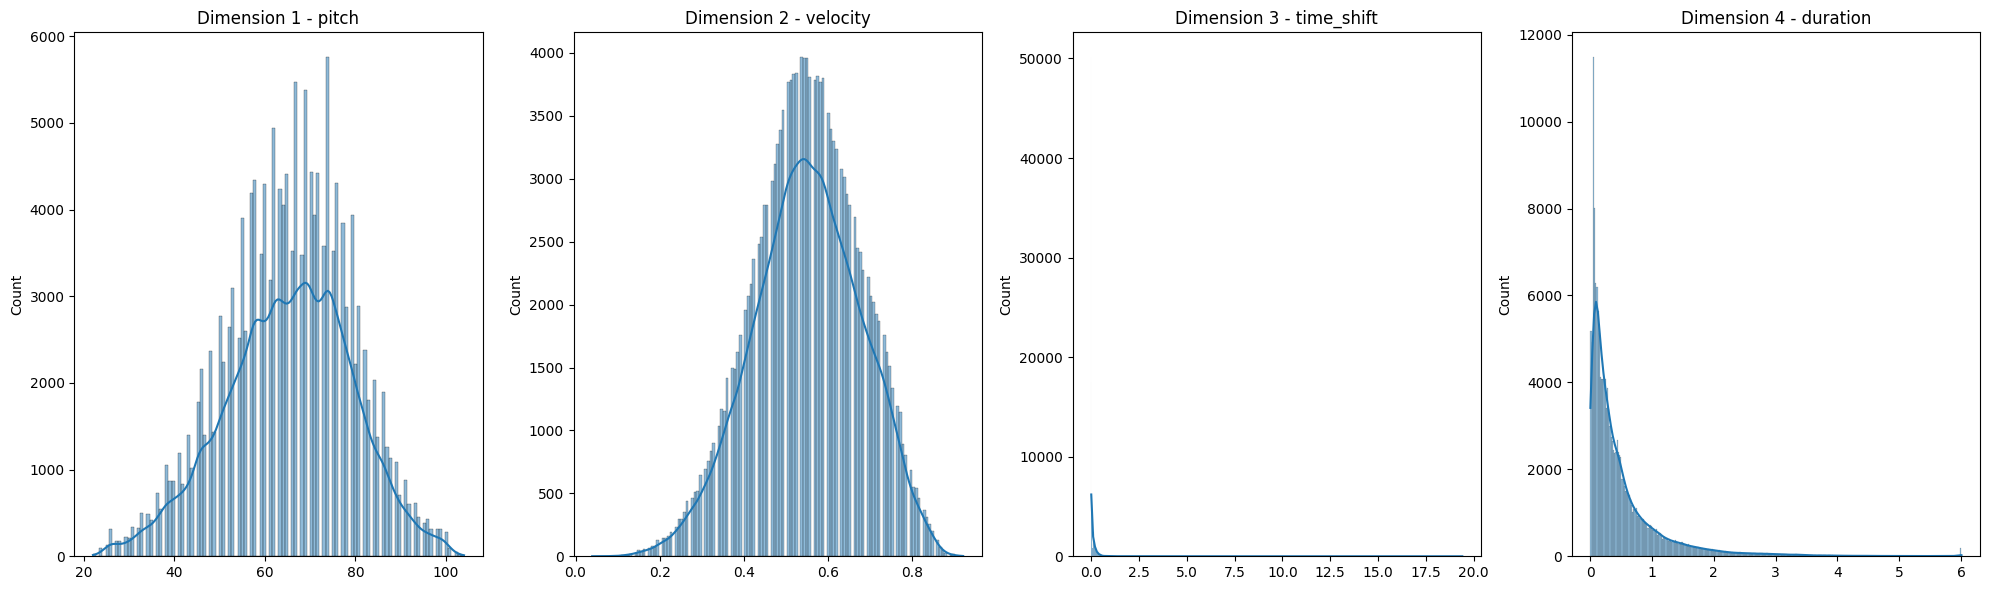

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


pos_to_dim = {
    0: "pitch",
    1: "velocity",
    2: "time_shift",
    3: "duration",
}

def plot_distribution(data, title):
    fig, ax = plt.subplots(1, 4, figsize=(20, 6))
    for i in range(4):
        sns.histplot(data[:, i], kde=True, ax=ax[i])
        ax[i].set_title(f"Dimension {i + 1} - {pos_to_dim[i]}")
    fig.tight_layout()
np_data = np.concatenate(dataset.midi_list[0:5000], axis=0)
print(np_data.shape)
plot_distribution(np_data, "MIDI Note Events Distribution")

In [7]:
import pandas as pd

def print_stats(np_data):
    print("Shape:", np_data.shape)
    mean = np.mean(np_data, axis=0)
    median = np.median(np_data, axis=0)
    std = np.std(np_data, axis=0)
    min_ = np.min(np_data, axis=0)
    max_ = np.max(np_data, axis=0)
    stats = pd.DataFrame({
        'Mean': mean,
        'Median': median,
        'Std': std,
        'Min': min_,
        'Max': max_
    }, index=[pos_to_dim[i] for i in range(4)])    
    print(stats)

print_stats(np_data)


Shape: (160000, 4)
                 Mean     Median        Std        Min         Max
pitch       65.315338  66.000000  13.937885  22.000000  104.000000
velocity     0.550378   0.551181   0.128285   0.039370    0.921260
time_shift   0.113195   0.026042   0.293222   0.000000   19.403646
duration     0.520509   0.289062   0.684336   0.003906    6.005208


In [8]:
eps = 1e-4
 # Ensure numpy uses float32 for consistency
def look_for_degenerates(np_data):
    degenerate_map = {
        "pitch": (np_data[:, 0] * 127 < 20) | (np_data[:, 0] * 127 > 110),
        "velocity": np_data[:, 1] < eps,
        "duration": np_data[:, 3] < eps
    }

    for i in range(4):
        name = pos_to_dim[i]
        if name == "time_shift":
            continue
        degenerate = degenerate_map[name]
        if np.any(degenerate):
            degenrate_count = np.sum(degenerate)
            degenrate_percentage = degenrate_count / np_data.shape[0] * 100
            print(f"{name} has {degenrate_count} degenerate values ({degenrate_percentage}) (less than {eps}):")

        else:
            print(f"{name} has no degenerate values.")

look_for_degenerates(np_data)

pitch has 160000 degenerate values (100.0) (less than 0.0001):
velocity has no degenerate values.
duration has no degenerate values.
